# 网络的验证

这种验证其实也就有些类似于目标检测的验证了，比分类问题复杂些，通过一些指标而非简单的分类标签来判定真伪。

如果先不看ggcnn中的思路，这块让我来做的话，分析一下，我们得到的网络输出是pos_img,ang_img和width_img，pos_img各点的值可以视作该点可抓不可抓的概率，图像大小为（300，300），太多了，那么我首先可以把最大值的1000个点筛选出来，然后找对对应的angle和width，凭借这三个参数就可以重建出这些点的抓取框，然后计算与真实各框的iou和jaccard指数等，如果都满足标准，就认为这是一次正确的抓取，这次预测也就是正确的了。

那就开整，流程应该是这样的：
- 首先是从网络的输出映射图中反求出各个实际参数代表的抓取框，主要就是要将cos和sin两个图反求出angle。
- 然后要明确一下成功的标准，然后写函数计算这些标准，最后再集成到类或者函数里面，思路还是很明确的。
  - 1.IoU>某个阈值
  - 2.jaccard index
  - 3.angle<某个阈值（即使重合度很高，角度差太远也是不行的）
 
最后，与之前程序的结合之处应当这样写：先对网络进行训练，每隔一定时间，执行验证函数，验证函数需要从外部载入的只有验证集数据和刚刚训练过的网络模型，在验证函数内部对验证集中的样本进行逐一预测，计算前面所设计的两个指标，如果满足，则正确样本数加1，最后的正确率=正确样本数/验证集样本总数。

## 1.原始输出数据的处理及其中有效抓取框的提取
此处注意，思路应当是这样的，先提取出所有的有效抓取框，也即，抓取概率为1的抓取框都应该提取出来作为候选，至于这些框中的哪些是正确的，就交由后面的两个指标来判断

### 1.1原始输出数据的处理
首先是通过原始的输出映射四张图把数据读出来，这边我们先运行一个训练，得到一下训练输出，然后方便处理

In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from train.cornell_pro import Cornell
from train.ggcnn import GGCNN

#准备数据集
cornell_data = Cornell('cornell')
dataset = torch.utils.data.DataLoader(cornell_data,batch_size = 32)

#从数据集中读取一个样本
for x,y in dataset:
    xc = x
    yc = y
    break
    
#实例化一个网络
net = GGCNN(4)

#定义一个优化器
optimizer = optim.Adam(net.parameters())

#为了能够看出效果，就在这个样本上多训练几次，得到一个很擅长这个样本的模型，然后拿它做预测输出

for i in range(50):
    losses = net.compute_loss(xc,yc)
    
    loss = losses['loss']
    print(i,loss)
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()



0 tensor(1.2139, grad_fn=<AddBackward0>)
1 tensor(1.1628, grad_fn=<AddBackward0>)
2 tensor(1.1113, grad_fn=<AddBackward0>)
3 tensor(1.0550, grad_fn=<AddBackward0>)
4 tensor(0.9881, grad_fn=<AddBackward0>)
5 tensor(0.8999, grad_fn=<AddBackward0>)
6 tensor(0.7815, grad_fn=<AddBackward0>)
7 tensor(0.6288, grad_fn=<AddBackward0>)
8 tensor(0.4492, grad_fn=<AddBackward0>)
9 tensor(0.2769, grad_fn=<AddBackward0>)
10 tensor(0.1937, grad_fn=<AddBackward0>)
11 tensor(0.3168, grad_fn=<AddBackward0>)
12 tensor(0.3274, grad_fn=<AddBackward0>)
13 tensor(0.2193, grad_fn=<AddBackward0>)
14 tensor(0.1309, grad_fn=<AddBackward0>)
15 tensor(0.1051, grad_fn=<AddBackward0>)
16 tensor(0.1194, grad_fn=<AddBackward0>)
17 tensor(0.1414, grad_fn=<AddBackward0>)
18 tensor(0.1540, grad_fn=<AddBackward0>)
19 tensor(0.1525, grad_fn=<AddBackward0>)
20 tensor(0.1388, grad_fn=<AddBackward0>)
21 tensor(0.1181, grad_fn=<AddBackward0>)
22 tensor(0.0991, grad_fn=<AddBackward0>)
23 tensor(0.0935, grad_fn=<AddBackward0>)
24

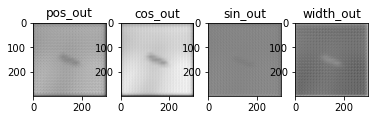

In [2]:
#将输入传递到网络并计算输出
pos,cos,sin,width = net.forward(xc)

#可视化看一下输出是是一个相对合理的预测
num = 20

plt.subplot(141)
plt.title('pos_out')
plt.imshow(pos[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(142)
plt.title('cos_out')
plt.imshow(cos[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(143)
plt.title('sin_out')
plt.imshow(sin[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(144)
plt.title('width_out')
plt.imshow(width[num][0].data.numpy(),cmap=plt.cm.gray)
plt.show()

看起来还不错，下面开始数据的读取和反求。

首先是反求一下角度数据，同时对三个数据进行一下降维处理。

In [3]:
q_img = pos.data.numpy().squeeze()#squeeze的作用通过处理前后张量的shape就可以看出来，对于单通道的图像，可视化以及后面计算的时候是不要需要第三个维度的，所以去掉了
ang_img = (torch.atan2(sin, cos) / 2.0).data.numpy().squeeze()
width_img = width.data.numpy().squeeze()

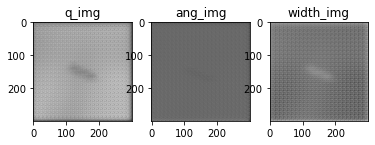

In [4]:
#可视化一下看看效果，主要是看ang_img，其他俩都没变
plt.subplot(131)
plt.title('q_img')
plt.imshow(q_img[num],cmap=plt.cm.gray)
plt.subplot(132)
plt.title('ang_img')
plt.imshow(ang_img[num],cmap=plt.cm.gray)
plt.subplot(133)
plt.title('width_img')
plt.imshow(width_img[num],cmap=plt.cm.gray)
plt.show()

在真正计算之前，还需要进行一个高斯滤波，原因论文中已经说过了，前面与已经可视化了滤波之前的效果，后面滤波一下，然后再看效果

In [5]:
from skimage.filters import gaussian
#注意此处要加上一个索引，也就是传入一个样本到gaussian函数，q_img[num],而不能将q_img整个传入，否则后面的运算会出问题，guassian这个函数无法批量处理多样本，
q_img_g = gaussian(q_img[num], 2.0, preserve_range=True)
ang_img_g = gaussian(ang_img[num], 2.0, preserve_range=True)
width_img_g = gaussian(width_img[num], 1.0, preserve_range=True)

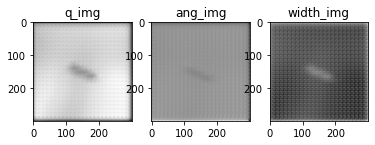

In [6]:
#可视化一下看看高斯滤波后的效果
plt.subplot(131)
plt.title('q_img')
plt.imshow(q_img_g,cmap=plt.cm.gray)
plt.subplot(132)
plt.title('ang_img')
plt.imshow(ang_img_g,cmap=plt.cm.gray)
plt.subplot(133)
plt.title('width_img')
plt.imshow(width_img_g,cmap=plt.cm.gray)
plt.show()

可以看到输出平滑了许多，而且对比度也有所增加，具体的效果可以后面再做对比实验比对，但作者是做了对比实验的，经过高斯过滤后动态抓取效果要好很多。

### 1.2有效抓取的提取
这块按照我的想法就是设置一个阈值，比如1，使用np.where()函数就可以找出所有满足这个阈值的点坐标，然后挨个把他们对应的其他两个参数读出来，这样定义一个抓取的所有三个参数就都有了，可以把它构造成前面设计的Grasp类，再处理的话就方便多了。

我看ggcnn的思路也是类似，但是对于最开始的有效点的提取，他直接用了一个函数peak_local_max，来自skimage.feature,我觉得可以学习一下，具体学习过程见support files，这里就直接拿来用了：

## 2.标准的确定
### 2.1 IoU的计算
全称Intersection over Union
![IoU计算示意图](images/iou.png)

计算IoU程序的设计思路可以参考：https://blog.csdn.net/u014061630/article/details/82818112

先不考虑具体细节实施的话，这块的流程可以总结为一下几点：
- 从网络输出中提取出面向本样本所有的有效抓取框（通过q_img来判定，这个工作前面已完成）
- 从原始数据集中获取该样本的真实标注Grasps，对于每一个有效抓取框，计算其与真实标注中每一个标注框的iou值，角度等指标是否符合标准，如果各项标注都符合，则认为这个预测框是正确的，进而认为本次预测是正确的。

好的，开整